In [45]:
import pandas as pd
# pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score
from scipy.sparse import csr_matrix
import xgboost as xgb
from xgboost import XGBClassifier
import pickle
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# load feature importance
fi = pd.read_csv('../results/xgb_feature_importances_v1_top500.csv', index_col=0)
products = pd.read_csv('../data/products.csv', index_col=0, usecols=['product_id', 'product_name'])

# build product name dictionary for product_ids in strings
products_dict_string = {}
for k, v in products.to_dict()['product_name'].items():
    products_dict_string[str(k)] = v

fi = fi.rename(columns=products_dict_string, index=products.to_dict()['product_name'])
fi.head()

,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Strawberries,Limes,Organic Whole Milk,Organic Raspberries,...,order_hod_15,order_hod_16,order_hod_17,order_hod_18,order_hod_19,order_hod_20,order_hod_21,order_hod_22,order_hod_23,Banana
Banana,16429.526711,1279.071116,517.772529,39.502174,2750.613134,775.537591,1600.779739,61.527677,804.173961,36.919135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bag of Organic Bananas,NaN,2301.037867,1715.161014,4171.241089,27.711317,18.298088,29.048433,24.578167,770.728439,1822.199426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22385.882321
Organic Strawberries,2576.305969,NaN,1995.664821,2642.691564,1013.659842,31.463527,2321.034563,166.930545,1994.481109,5175.236566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1543.809114
Organic Baby Spinach,1699.331320,2290.482298,NaN,3773.820365,5673.249576,1449.552438,27.865870,346.613926,432.487979,17.776998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,499.537555
Organic Hass Avocado,9399.550122,4647.737054,3132.413388,NaN,3506.243967,134.378344,178.815864,2337.994997,45.859021,2778.636262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.096809


In [16]:
# normalize values
arr = fi.fillna(0).values
arr = normalize(arr, norm='max', axis=1)
fi_norm = pd.DataFrame(arr, index=fi.index, columns=fi.columns)
display(fi_norm.head())
fi_norm.to_csv('../results/xgb_feature_importances_v1_top500_norm.csv')

,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Strawberries,Limes,Organic Whole Milk,Organic Raspberries,...,order_hod_15,order_hod_16,order_hod_17,order_hod_18,order_hod_19,order_hod_20,order_hod_21,order_hod_22,order_hod_23,Banana
Banana,1.000000,0.077852,0.031515,0.002404,0.167419,0.047204,0.097433,0.003745,0.048947,0.002247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bag of Organic Bananas,0.000000,0.102790,0.076618,0.186334,0.001238,0.000817,0.001298,0.001098,0.034429,0.081399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
Organic Strawberries,0.497814,0.000000,0.385618,0.510642,0.195867,0.006080,0.448489,0.032256,0.385389,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298307
Organic Baby Spinach,0.276900,0.373226,0.000000,0.614931,0.924437,0.236200,0.004541,0.056480,0.070472,0.002897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081398
Organic Hass Avocado,1.000000,0.494464,0.333251,0.000000,0.373023,0.014296,0.019024,0.248735,0.004879,0.295614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007883


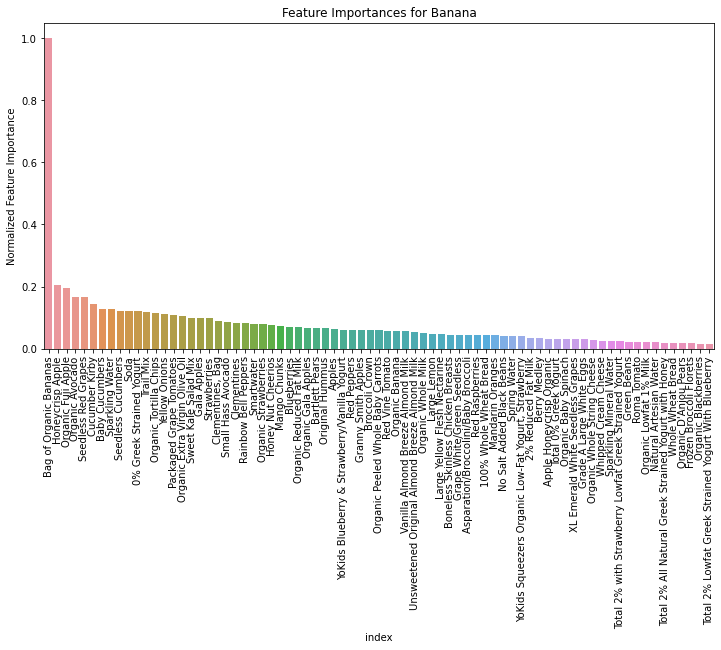

In [65]:
# plot top feature importances

product_of_interest = 'Banana'
num_features = 75

feature_importances = fi_norm.loc[product_of_interest]
feature_importances = feature_importances.sort_values(ascending=False)[:num_features]

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances.reset_index(), x='index', y=product_of_interest)
plt.xticks(rotation=90)
plt.title(f"Feature Importances for {product_of_interest}")
plt.ylabel('Normalized Feature Importance')

plt.savefig(img)

In [61]:
img.seek(0)

0

In [55]:
img = StringIO()

In [58]:
img = BytesIO()

In [62]:
base64.b64encode(img.getvalue())

b'iVBORw0KGgoAAAANSUhEUgAAA2AAAAGwCAYAAADPMwaiAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAABL0ElEQVR4nO3dd5hsVZX38e8PDBgIBkxkEUVUUMSMY84Bs2LGnOMY5h3j6DjqGMaMqCBmMSOi6KiAGEaJIo6MCAbEAIYBAQO43j/2KW7RdN+6DLf3qb73+3meerrPqareq6tDnbXD2qkqJEmSJEnLb4OxA5AkSZKk9YUJmCRJkiR1YgImSZIkSZ2YgEmSJElSJyZgkiRJktSJCZgkSZIkdWICJkmSJEmdmIBJkiRJUicmYJIkSZLUiQmYJEmSJHViAiZJkiRJnZiASZIkSVInJmCSJEmS1IkJmCRJkiR1YgImSZIkSZ2YgEmSJElSJyZgkiRJktSJCZgkSZIkdWICJkmSJEmdmIBJkiRJUicmYJIkSZLUiQmYJEmSJHViAiZJkiRJnZiASZIkSVInJmCSJEmS1IkJmCRJkiR1YgImSZIkSZ2YgEmSJElSJyZgkiRJktSJCZgkSZIkdWICJkmSJEmdmIBJkiRJUicmYJIkSZLUiQmYJEmSJHViAiZJkiRJnZiASZK0zJK8OskZSX49diySpHGZgEnSMkvy0yTnJvnT1O1aa+Fr3nltxbgG7b0iyYd6tbc6SR6b5Iix41hTSbYCng/sVFXXWEtfs5KcPfwunZHko0k2WxtfW5K0vEzAJKmP+1TVFadup40ZTJJLjdn+/9UKjXsb4HdV9duL+8QZ3+8uVXVF4NrAlYBX/N/CkyT1ZAImSSNJsmmS9yX5VZJfDtPUNhzu2z7J15L8bhjh+PBkhCPJB4Gtgc8PIyAvTHL7JKcu+PoXjJINI1ifTPKhJGcCj11d+2sQeyV5WpIfJzkryauGmL+d5MwkBy